
# WindDatas – Analyse technique des données de vent

Ce notebook constitue la **base technique robuste** pour l'analyse complète des données de vent dans le cadre du projet **WindDatas**.

Il a été conçu pour :
- être **modulaire et générique**, adapté à tous les sites présents dans `../data/`
- produire une **analyse rigoureuse, reproductible et documentée**
- servir de fondation pour des enrichissements futurs (page de garde, exports Word, ajout de modèles, etc.)

---

### Structure du notebook :
1. Imports techniques et configuration
2. Sélection dynamique du site
3. Chargement automatisé des données
4. Vérification des colonnes critiques
5. Préparation et fusion des données
6. Analyses statistiques et visuelles détaillées
7. Détection des extrêmes
8. Ajustement de lois (Weibull / Gumbel)
9. Comparaison inter-sources


In [42]:

# ============================================================
# 📦 Imports globaux – tous en tête pour éviter les erreurs
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import radians
from scipy.stats import weibull_min, gumbel_r
import warnings

# 📉 Configuration visuelle
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (10, 4)
sns.set_style("whitegrid")

# 🔇 Suppression des warnings
warnings.filterwarnings("ignore")


In [43]:
import os

try:
    base_data_path = os.path.abspath(os.path.join("..", "data"))
    available_sites = sorted([d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))])

    if not available_sites:
        raise Exception("Aucun dossier de site trouvé dans ../data")

    print("Sites disponibles :")
    for i, site in enumerate(available_sites):
        print(f"{i+1}. {site}")

    index = int(input("Entrez le numéro du site à analyser : ")) - 1

    site_name = available_sites[index]
    data_path = os.path.join(base_data_path, site_name)

    print(f"[✅] Site sélectionné : {site_name}")
    print(f"[📁] Chemin des données : {data_path}")

except Exception as e:
    print(f"[❌] Erreur dans la sélection du site : {e}")


Sites disponibles :
1. TEST_PARIS_Montsouris
2. WFR001_PIOLENC
3. WFR006_CARBONNE
4. WFR049_SALLES_SUR_GARONNE
5. WFR066_GROILLONS
6. WFR070_MADONE
7. WFR090_MONPEZAT
8. WIL010_Nofar Pilot
9. WIL017_ASHDOT
10. WIL045_KFAR HAMACCABI (KHM)
11. WIN160_RUMSL
12. WIT001_PONTECORVO
13. WJP104_YAMAKURA
14. WLU001_DIFFERDANGE
15. WNL001_AZALEALAAN
16. WNL005_WATTCO (Pilot)
17. WNL006_ALPEN WATTCO = Maxima Bridge
18. WNL009_ENGIE POND HQ = Engie Zaandam
19. WNL024_BURGUM CENTRAL = Engie Burgum
20. WNL026_OOSTERHOF HOLFMAN
21. WNL031_VELDHUNTEN
22. WNL049_K3
23. WNL059_ZALTBOMMEL
24. WPT008_ALTO_RABAGAO
25. WPT016_SAO LUIS = Cegonha
26. WPT026_CUBA ESTE
27. WSE001_BOR
28. WTW059_CHANGBIN
29. WUK003_QE2
30. WUK013_SHEEPLANDS FARM
31. WUK025_GODLEY RESERVOIR
32. WUK027_KEENS FARM
33. WUK028_WOODLANE
34. WUK029_PARK FARM
35. WUK045_POLYBELL
36. WUK063_REEDERS RESERVOIR
[✅] Site sélectionné : WFR006_CARBONNE
[📁] Chemin des données : c:\Users\AdrienSALICIS\Ciel & Terre International\R&D - Ressources 

In [44]:

# ============================================================
# 📥 Chargement automatisé des fichiers CSV
# ============================================================

dataframes = {}
for file in os.listdir(data_path):
    if file.endswith(".csv"):
        key = file.replace(".csv", "")
        try:
            df = pd.read_csv(os.path.join(data_path, file))
            if "time" in df.columns:
                df["time"] = pd.to_datetime(df["time"])
            elif "date" in df.columns:
                df = df.rename(columns={"date": "time"})
                df["time"] = pd.to_datetime(df["time"])
            if "time" in df.columns:
                df = df.sort_values("time")
            dataframes[key] = df
            print(f"[✅] {key} chargé ({len(df)} lignes)")
        except Exception as e:
            print(f"[❌] Erreur lecture {file} : {e}")


[✅] era5_CARBONNE chargé (438336 lignes)
[✅] era5_daily_CARBONNE chargé (18264 lignes)
[✅] meteostat1_CARBONNE chargé (2927 lignes)
[✅] meteostat2_CARBONNE chargé (4995 lignes)
[✅] nasa_power_CARBONNE chargé (18264 lignes)
[✅] noaa_station1_CARBONNE chargé (4915 lignes)
[✅] noaa_station2_CARBONNE chargé (4200 lignes)
[✅] openmeteo_CARBONNE chargé (18264 lignes)
[✅] openmeteo_CARBONNE_lat43.31_lon1.19 chargé (18264 lignes)
[✅] power_CARBONNE chargé (18264 lignes)
[✅] stations_CARBONNE chargé (4 lignes)
[✅] statistics_comparison_CARBONNE chargé (21 lignes)


In [45]:

# ============================================================
# 📍 Résumé du site et période couverte
# ============================================================

site_info = {
    "Nom du site": site_name,
    "Fichiers disponibles": list(dataframes.keys())
}

all_dates = []
for df in dataframes.values():
    if "time" in df.columns:
        all_dates.extend(df["time"].dropna().tolist())

if all_dates:
    start = min(all_dates).date()
    end = max(all_dates).date()
    site_info["Période d’étude"] = f"{start} → {end}"
else:
    site_info["Période d’étude"] = "Inconnue"

print("📌 Informations sur le site :\n")
for key, value in site_info.items():
    print(f"- {key} : {value}")


📌 Informations sur le site :

- Nom du site : WFR006_CARBONNE
- Fichiers disponibles : ['era5_CARBONNE', 'era5_daily_CARBONNE', 'meteostat1_CARBONNE', 'meteostat2_CARBONNE', 'nasa_power_CARBONNE', 'noaa_station1_CARBONNE', 'noaa_station2_CARBONNE', 'openmeteo_CARBONNE', 'openmeteo_CARBONNE_lat43.31_lon1.19', 'power_CARBONNE', 'stations_CARBONNE', 'statistics_comparison_CARBONNE']
- Période d’étude : 1975-01-01 → 2025-06-03



## Analyse statistique des vitesses moyennes et rafales

Ce bloc calcule des statistiques de base pour chaque source de données disponible :  
- nombre de valeurs (`count`)
- moyenne (`mean`)
- écart-type (`std`)
- minimum et maximum
- quantiles à 5%, 25%, 50%, 75%, 95%

Ces indicateurs permettent d'évaluer la cohérence et la dispersion des données issues de chaque source météo.


In [46]:
# ============================================================
# 📊 Statistiques descriptives regroupées (moyenne du vent)
# ============================================================

stats_summary = {}
for name, df in dataframes.items():
    if "windspeed_mean" in df.columns:
        stats = df["windspeed_mean"].describe(percentiles=[.05, .25, .5, .75, .95])
        stats_summary[name] = stats

df_stats = pd.DataFrame(stats_summary).T[
    ["count", "mean", "std", "min", "5%", "25%", "50%", "75%", "95%", "max"]
]

# ✅ Mise en forme visuelle à 2 décimales uniquement à l'affichage
display(
    df_stats.style
    .format(precision=2)
    .set_caption("📊 Statistiques descriptives des vitesses moyennes")
)


,count,mean,std,min,5%,25%,50%,75%,95%,max
era5_CARBONNE,438336.00,2.54,1.46,0.00,0.73,1.48,2.20,3.30,5.41,13.61
era5_daily_CARBONNE,18264.00,3.91,1.63,1.01,1.90,2.66,3.57,4.82,7.07,13.61
meteostat1_CARBONNE,2927.00,12.11,5.88,1.70,4.90,7.60,10.80,15.50,23.27,45.90
meteostat2_CARBONNE,4995.00,11.54,5.79,0.30,4.70,7.10,10.30,14.80,22.50,45.90
nasa_power_CARBONNE,16072.00,3.52,1.51,0.80,1.71,2.43,3.18,4.29,6.49,12.08
noaa_station1_CARBONNE,4915.00,5.82,2.45,1.00,2.60,4.10,5.70,7.20,10.30,18.00
noaa_station2_CARBONNE,4200.00,5.84,2.55,1.00,2.60,3.60,5.70,7.20,10.30,18.00
openmeteo_CARBONNE,18264.00,9.39,4.41,1.90,4.20,6.10,8.30,11.70,18.10,36.10
openmeteo_CARBONNE_lat43.31_lon1.19,18264.00,9.39,4.41,1.90,4.20,6.10,8.30,11.70,18.10,36.10
power_CARBONNE,16072.00,3.52,1.51,0.80,1.71,2.43,3.18,4.29,6.49,12.08


In [47]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path

# 📁 Dossier des données (à adapter si besoin)
data_root = Path("data")
stat_results = []

# 🔍 Recherche des fichiers CSV dans les sous-dossiers
csv_files = list(data_root.glob("**/*.csv"))

# 📊 Fonction de calcul statistique
def compute_stats(df, source_name, site_name):
    for col in ["windspeed_mean", "windspeed_gust", "winddirection"]:
        if col in df.columns:
            data = df[col].dropna()
            stat_results.append({
                "Site": site_name,
                "Source": source_name,
                "Variable": col,
                "Count": len(data),
                "Mean": data.mean(),
                "Median": data.median(),
                "Std": data.std(),
                "Min": data.min(),
                "Max": data.max(),
                "P90": data.quantile(0.90),
                "P95": data.quantile(0.95),
                "P99": data.quantile(0.99),
            })

# 🔄 Parcours de tous les fichiers CSV
for file in csv_files:
    try:
        df = pd.read_csv(file)
        site_name = file.parts[-2]  # nom du dossier du site
        source_name = file.stem.split("_")[0]  # meteostat1, noaa_station2...
        compute_stats(df, source_name, site_name)
    except Exception as e:
        print(f"⚠️ Erreur lecture {file}: {e}")

# 📑 Création du DataFrame récapitulatif
df_stats = pd.DataFrame(stat_results)

# 💾 Option : export CSV si besoin
# df_stats.to_csv("resume_stats_vent.csv", index=False)

# 👀 Affichage interactif
display(df_stats.head(20))  # ou df_stats si tu veux tout voir


""



## Histogrammes des vitesses moyennes du vent

Cette visualisation montre la distribution des vitesses moyennes par source, sous forme :
- d’histogramme (comptage ou densité)
- avec une courbe de densité lissée (KDE)

Cela permet de détecter des effets de seuil, des distributions asymétriques ou des valeurs aberrantes.


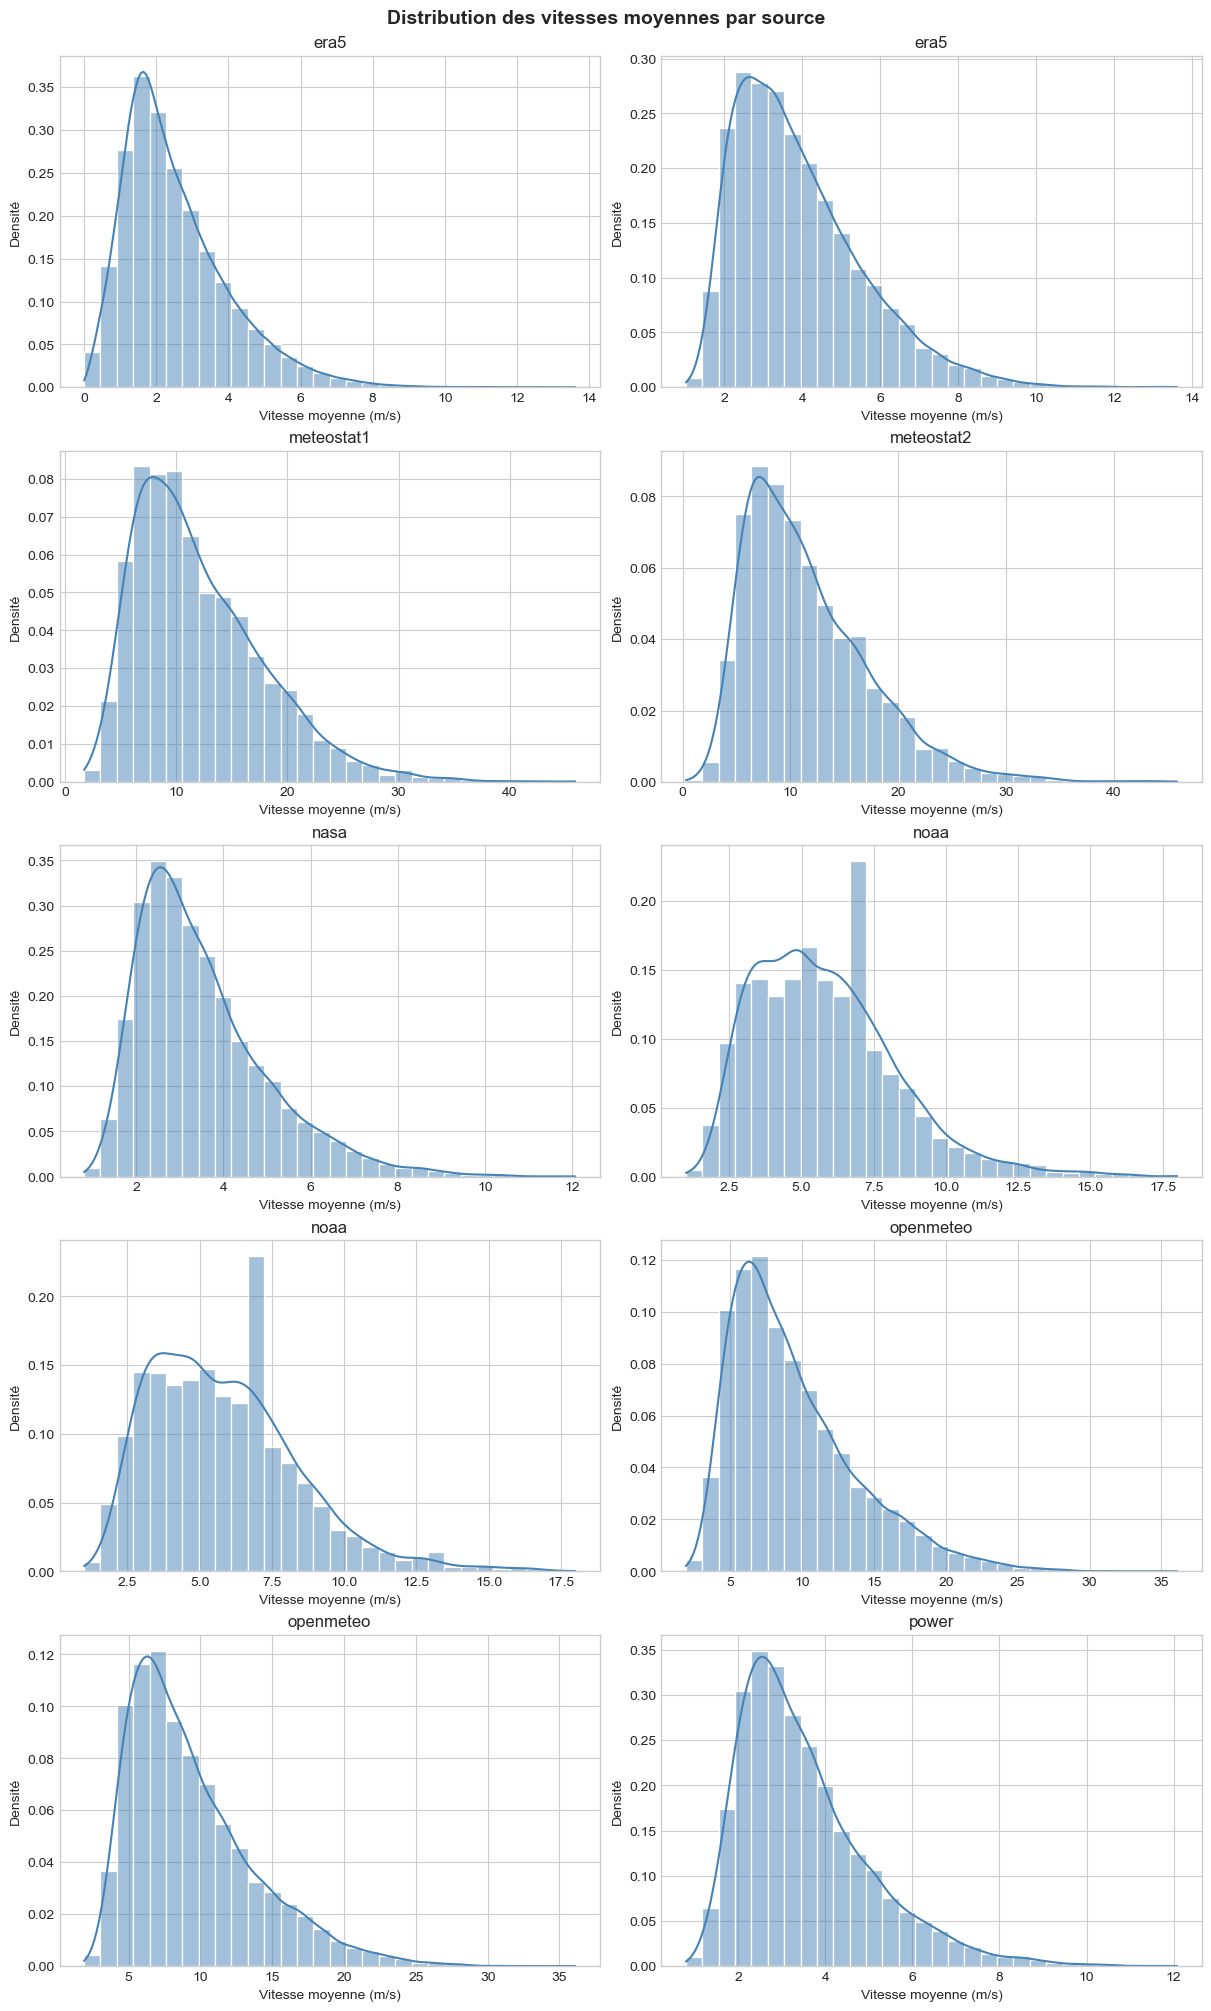

In [48]:
# ============================================================
# Histogrammes côte à côte par source (subplots)
# ============================================================

valid_sources = [(name.split('_')[0], df["windspeed_mean"].dropna()) for name, df in dataframes.items()
                 if "windspeed_mean" in df.columns and len(df["windspeed_mean"].dropna()) >= 10]

n = len(valid_sources)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten() if n > 1 else [axes]

for i, (name, data) in enumerate(valid_sources):
    ax = axes[i]
    sns.histplot(data, bins=30, kde=True, stat='density', color='steelblue', ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Vitesse moyenne (m/s)")
    ax.set_ylabel("Densité")
    ax.grid(True)

# Supprimer les sous-graphiques inutiles si n est impair
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution des vitesses moyennes par source", fontsize=14, fontweight='bold')
plt.show()





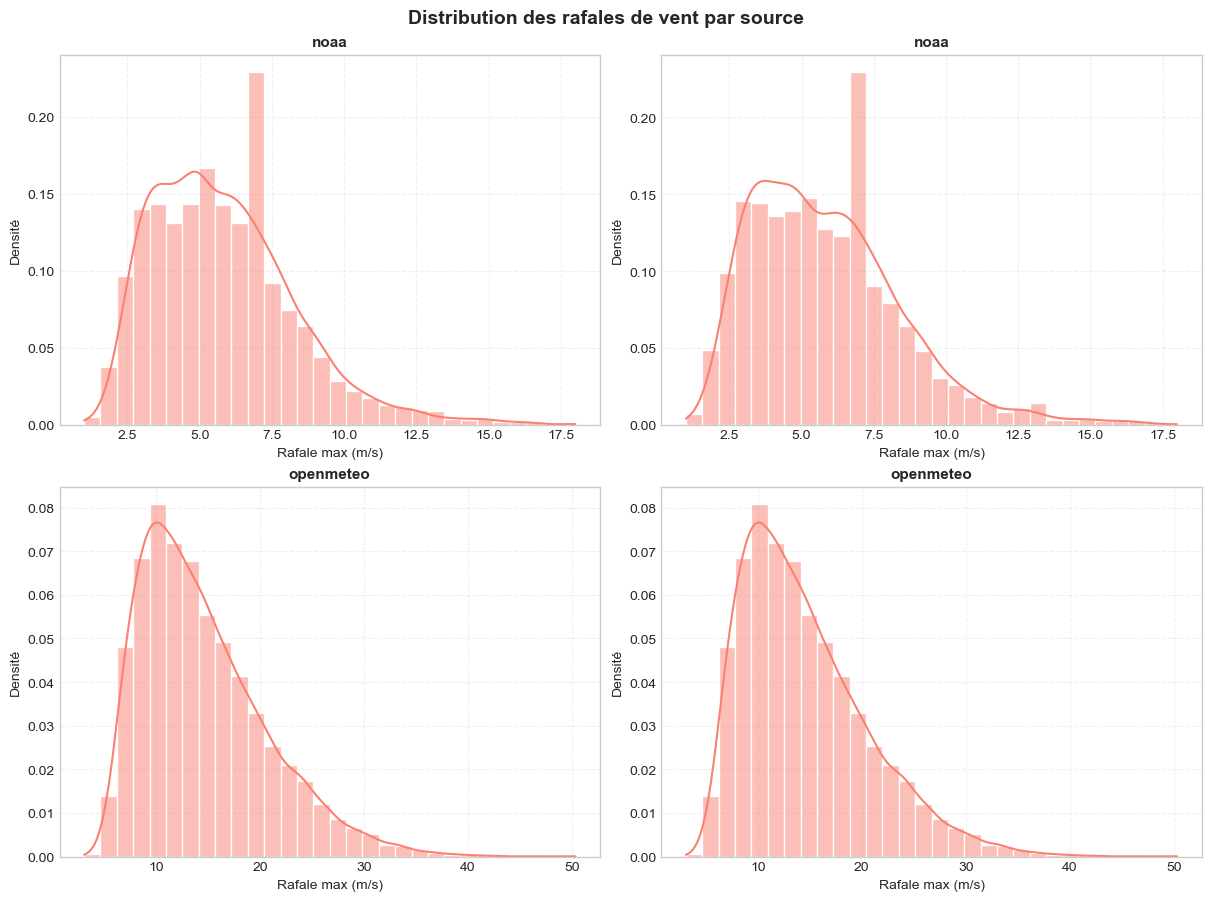

In [49]:
# ============================================================
# Histogrammes groupés – rafales de vent par source
# ============================================================

valid_gust_sources = [
    (name.split('_')[0], df["windspeed_gust"].dropna())
    for name, df in dataframes.items()
    if "windspeed_gust" in df.columns and len(df["windspeed_gust"].dropna()) >= 10
]

n = len(valid_gust_sources)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])


fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)

# Correction ici
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

axes = axes.flatten()

for i, (name, data) in enumerate(valid_gust_sources):
    ax = axes[i]
    sns.histplot(data, bins=30, kde=True, stat='density', color='salmon', ax=ax)
    ax.set_title(name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Rafale max (m/s)")
    ax.set_ylabel("Densité")
    ax.grid(True, linestyle='--', alpha=0.3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution des rafales de vent par source", fontsize=14, fontweight='bold')
plt.show()



## Comparaison visuelle – Boxplot

Le boxplot (ou boîte à moustaches) affiche :
- médiane (trait central)
- quartiles (boîte)
- valeurs extrêmes (points hors boîte)

Il est utilisé ici pour comparer visuellement les distributions de vitesses moyennes entre sources.


,outliers
era5,12795
openmeteo,1022
nasa,476
power,476
noaa,201
meteostat2,100
meteostat1,56


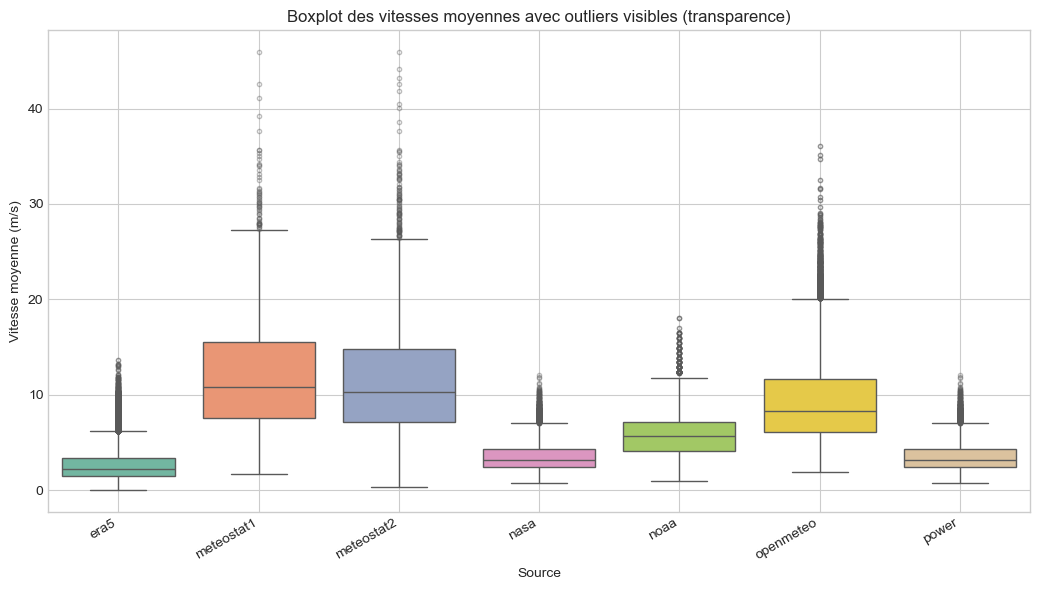

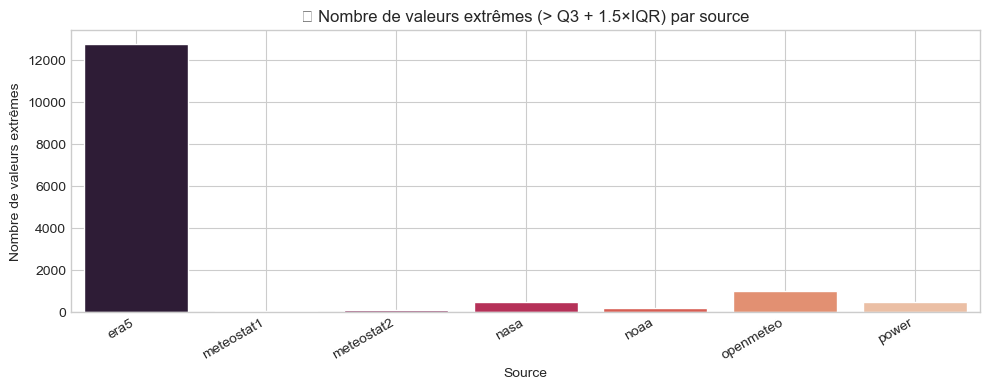

In [50]:
# ============================================================
# Boxplot avec outliers visibles + comptage des extrêmes
# ============================================================

# Fusionner les données
df_all_box = pd.concat([
    df.assign(source=name.split("_")[0])  # Nettoyage du nom
    for name, df in dataframes.items()
    if "windspeed_mean" in df.columns
], ignore_index=True)


# Détection des outliers par Tukey (Q3 + 1.5 × IQR)
outlier_counts = {}
for source in df_all_box["source"].unique():
    data = df_all_box[df_all_box["source"] == source]["windspeed_mean"].dropna()
    if len(data) < 10:
        continue
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_val = q3 - q1
    seuil_sup = q3 + 1.5 * iqr_val
    outlier_counts[source] = (data > seuil_sup).sum()

# Afficher le tableau
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["outliers"])
display(outlier_df.sort_values(by="outliers", ascending=False).style.set_caption("🔍 Nombre de valeurs extrêmes par source (> Q3 + 1.5×IQR)"))

# Afficher le boxplot avec outliers
fig, ax = plt.subplots(figsize=(max(10, len(outlier_counts) * 1.5), 6))
sns.boxplot(
    data=df_all_box,
    x="source",
    y="windspeed_mean",
    order=outlier_df.index,
    showfliers=True,
    flierprops=dict(marker='o', markersize=3, alpha=0.4),
    palette="Set2",
    ax=ax
)

ax.set_title("Boxplot des vitesses moyennes avec outliers visibles (transparence)")
ax.set_ylabel("Vitesse moyenne (m/s)")
ax.set_xlabel("Source")
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Histogramme du nombre de valeurs extrêmes
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    x=outlier_df.index,
    y=outlier_df["outliers"],
    palette="rocket",
    ax=ax
)
ax.set_title("📊 Nombre de valeurs extrêmes (> Q3 + 1.5×IQR) par source")
ax.set_ylabel("Nombre de valeurs extrêmes")
ax.set_xlabel("Source")
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()




## Détection des valeurs extrêmes (potentiellement aberrantes)

Certaines valeurs de vent très élevées peuvent correspondre à :
- des évènements météorologiques rares
- ou des erreurs de capteur / données mal encodées

Ce bloc détecte les valeurs supérieures à un seuil configurable (`50 m/s` par défaut), et les affiche classées par ordre décroissant.


In [51]:
# ============================================================
# 🚨 Détection des vitesses moyennes ou rafales anormales (seuil par type)
# ============================================================

seuils_min = {
    "windspeed_mean": 8,
    "windspeed_gust": 15
}

for name, df in dataframes.items():
    for col in ["windspeed_gust", "windspeed_mean"]:
        if col in df.columns:
            data = df[col].dropna()
            if data.empty:
                continue

            seuil = max(seuils_min[col], data.quantile(0.95))
            extremes = df[df[col] > seuil]

            print(f"📊 {name} – {col} – max: {data.max():.2f} m/s – seuil: {seuil:.2f} m/s")
            if not extremes.empty:
                print(f"⚠️ {len(extremes)} valeurs > seuil ({seuil:.2f} m/s)")
                display(extremes.sort_values(by=col, ascending=False)[["time", col]].head(10))

📊 era5_CARBONNE – windspeed_mean – max: 13.61 m/s – seuil: 8.00 m/s
⚠️ 1534 valeurs > seuil (8.00 m/s)


,time,windspeed_mean
219044,1999-12-27 20:00:00,13.607158
298621,2009-01-24 13:00:00,13.200095
184992,1996-02-08 00:00:00,13.155159
219045,1999-12-27 21:00:00,13.146968
184991,1996-02-07 23:00:00,13.068635
298617,2009-01-24 09:00:00,12.938077
298619,2009-01-24 11:00:00,12.701494
16828,1976-12-02 04:00:00,12.614981
184993,1996-02-08 01:00:00,12.152994
16829,1976-12-02 05:00:00,12.090703


📊 era5_daily_CARBONNE – windspeed_mean – max: 13.61 m/s – seuil: 8.00 m/s
⚠️ 409 valeurs > seuil (8.00 m/s)


,time,windspeed_mean
9126,1999-12-27,13.607158
12442,2009-01-24,13.200095
7708,1996-02-08,13.155159
7707,1996-02-07,13.068635
701,1976-12-02,12.614981
16498,2020-03-03,11.917771
8161,1997-05-06,11.776795
16417,2019-12-13,11.719484
7036,1994-04-07,11.630043
9127,1999-12-28,11.553220


📊 meteostat1_CARBONNE – windspeed_mean – max: 45.90 m/s – seuil: 23.27 m/s
⚠️ 147 valeurs > seuil (23.27 m/s)


,time,windspeed_mean
1393,2017-02-13,45.9
416,2014-03-29,42.6
1915,2022-03-15,41.1
1528,2021-02-21,39.2
967,2015-11-02,37.6
420,2014-04-02,35.7
2668,2024-04-06,35.7
1922,2022-03-22,35.3
1392,2017-02-12,35.0
1921,2022-03-21,34.7


📊 meteostat2_CARBONNE – windspeed_mean – max: 45.90 m/s – seuil: 22.50 m/s
⚠️ 249 valeurs > seuil (22.50 m/s)


,time,windspeed_mean
2197,2017-02-13,45.9
805,2012-10-18,44.2
2569,2018-03-01,43.2
1184,2014-03-29,42.6
3972,2022-03-15,41.8
3585,2021-02-21,40.5
3176,2019-12-13,40.1
2606,2018-04-07,38.6
1733,2015-11-02,37.6
1188,2014-04-02,35.7


📊 nasa_power_CARBONNE – windspeed_mean – max: 12.08 m/s – seuil: 8.00 m/s
⚠️ 227 valeurs > seuil (8.00 m/s)


,time,windspeed_mean
12442,2009-01-24,12.08
16417,2019-12-13,11.88
5170,1989-02-26,11.71
5522,1990-02-13,11.29
3325,1984-02-08,11.12
4040,1986-01-23,10.79
5521,1990-02-12,10.74
6197,1991-12-20,10.65
12030,2007-12-09,10.62
7036,1994-04-07,10.51


📊 noaa_station1_CARBONNE – windspeed_gust – max: 18.00 m/s – seuil: 15.00 m/s
⚠️ 16 valeurs > seuil (15.00 m/s)


,time,windspeed_gust
855,2012-10-18,18.0
2345,2017-03-06,18.0
1279,2014-04-02,16.5
856,2012-10-19,16.5
4417,2023-03-26,16.5
2867,2018-08-12,16.5
2324,2017-02-13,16.0
1580,2015-01-29,16.0
4075,2022-04-11,16.0
2703,2018-03-01,16.0


📊 noaa_station1_CARBONNE – windspeed_mean – max: 18.00 m/s – seuil: 10.30 m/s
⚠️ 210 valeurs > seuil (10.30 m/s)


,time,windspeed_mean
855,2012-10-18,18.0
2345,2017-03-06,18.0
1279,2014-04-02,16.5
4417,2023-03-26,16.5
2867,2018-08-12,16.5
856,2012-10-19,16.5
2703,2018-03-01,16.0
1580,2015-01-29,16.0
4075,2022-04-11,16.0
3427,2020-03-03,16.0


📊 noaa_station2_CARBONNE – windspeed_gust – max: 18.00 m/s – seuil: 15.00 m/s
⚠️ 19 valeurs > seuil (15.00 m/s)


,time,windspeed_gust
1496,2017-03-06,18.0
2496,2019-12-13,17.0
4125,2025-03-21,17.0
2018,2018-08-12,16.5
461,2014-04-02,16.5
373,2014-01-04,16.5
1853,2018-02-28,16.5
3564,2023-03-26,16.5
4124,2025-03-20,16.0
759,2015-01-29,16.0


📊 noaa_station2_CARBONNE – windspeed_mean – max: 18.00 m/s – seuil: 10.30 m/s
⚠️ 195 valeurs > seuil (10.30 m/s)


,time,windspeed_mean
1496,2017-03-06,18.0
2496,2019-12-13,17.0
4125,2025-03-21,17.0
2018,2018-08-12,16.5
373,2014-01-04,16.5
1853,2018-02-28,16.5
3564,2023-03-26,16.5
461,2014-04-02,16.5
1854,2018-03-01,16.0
759,2015-01-29,16.0


📊 openmeteo_CARBONNE – windspeed_gust – max: 50.30 m/s – seuil: 26.30 m/s
⚠️ 900 valeurs > seuil (26.30 m/s)


,time,windspeed_gust
16417,2019-12-13,50.3
16498,2020-03-03,50.2
9126,1999-12-27,48.9
12442,2009-01-24,47.7
7708,1996-02-08,47.2
701,1976-12-02,45.5
15405,2017-03-06,45.2
15376,2017-02-05,44.4
16426,2019-12-22,42.9
8161,1997-05-06,42.3


📊 openmeteo_CARBONNE – windspeed_mean – max: 36.10 m/s – seuil: 18.10 m/s
⚠️ 913 valeurs > seuil (18.10 m/s)


,time,windspeed_mean
701,1976-12-02,36.1
15384,2017-02-13,35.1
16417,2019-12-13,34.7
17240,2022-03-15,32.5
3325,1984-02-08,31.7
15765,2018-03-01,31.6
5170,1989-02-26,30.7
16853,2021-02-21,30.4
16833,2021-02-01,29.7
18239,2024-12-08,29.1


📊 openmeteo_CARBONNE_lat43.31_lon1.19 – windspeed_gust – max: 50.30 m/s – seuil: 26.30 m/s
⚠️ 900 valeurs > seuil (26.30 m/s)


,time,windspeed_gust
16417,2019-12-13,50.3
16498,2020-03-03,50.2
9126,1999-12-27,48.9
12442,2009-01-24,47.7
7708,1996-02-08,47.2
701,1976-12-02,45.5
15405,2017-03-06,45.2
15376,2017-02-05,44.4
16426,2019-12-22,42.9
8161,1997-05-06,42.3


📊 openmeteo_CARBONNE_lat43.31_lon1.19 – windspeed_mean – max: 36.10 m/s – seuil: 18.10 m/s
⚠️ 913 valeurs > seuil (18.10 m/s)


,time,windspeed_mean
701,1976-12-02,36.1
15384,2017-02-13,35.1
16417,2019-12-13,34.7
17240,2022-03-15,32.5
3325,1984-02-08,31.7
15765,2018-03-01,31.6
5170,1989-02-26,30.7
16853,2021-02-21,30.4
16833,2021-02-01,29.7
18239,2024-12-08,29.1


📊 power_CARBONNE – windspeed_mean – max: 12.08 m/s – seuil: 8.00 m/s
⚠️ 227 valeurs > seuil (8.00 m/s)


,time,windspeed_mean
12442,2009-01-24,12.08
16417,2019-12-13,11.88
5170,1989-02-26,11.71
5522,1990-02-13,11.29
3325,1984-02-08,11.12
4040,1986-01-23,10.79
5521,1990-02-12,10.74
6197,1991-12-20,10.65
12030,2007-12-09,10.62
7036,1994-04-07,10.51



## Ajustement de lois de probabilité : Weibull et Gumbel

Nous utilisons deux lois statistiques classiques pour modéliser les vitesses de vent :
- **Weibull** : forme + échelle
- **Gumbel** : spécialisée dans l’étude des maxima (vents extrêmes)

Ces courbes sont ajustées sur les données observées pour chaque source, puis comparées visuellement à l’histogramme empirique.


In [ ]:

# ============================================================
# Ajustement de la loi de Weibull et Gumbel
# ============================================================

for name, df in dataframes.items():
    col = "windspeed_gust" if "windspeed_gust" in df.columns else "windspeed_mean"
    if col not in df.columns:
        continue

    data = df[col].dropna()
    if len(data) < 30:
        continue  # pas assez de données pour ajustement fiable

    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=30, stat='density', color='lightgray', label="Données empiriques")

    x_vals = np.linspace(data.min(), data.max(), 200)

    # Loi de Weibull (2 paramètres)
    c, loc, scale = weibull_min.fit(data, floc=0)
    weibull_pdf = weibull_min.pdf(x_vals, c, loc, scale)
    plt.plot(x_vals, weibull_pdf, label=f"Weibull (c={c:.2f}, scale={scale:.2f})")

    # Loi de Gumbel (maximum)
    loc_g, scale_g = gumbel_r.fit(data)
    gumbel_pdf = gumbel_r.pdf(x_vals, loc_g, scale_g)
    plt.plot(x_vals, gumbel_pdf, label="Gumbel")

    plt.title(f"Ajustement statistique – {name}")
    plt.xlabel("Vitesse (m/s)")
    plt.ylabel("Densité")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


## Comparaison croisée entre sources

Pour chaque paire de sources disponibles, nous comparons les valeurs disponibles en commun :
- Erreur absolue moyenne (MAE)
- Corrélation linéaire (Pearson)
- Nombre de jours communs

Les résultats sont affichés de manière synthétique et lisible.


In [ ]:
# ============================================================
# 🔁 Comparaison croisée – séparée pour windspeed_mean et windspeed_gust
# ============================================================

def compare_sources_by_variable(dataframes, variable):
    results = []
    keys = [k for k in dataframes.keys() if variable in dataframes[k].columns and "statistics" not in k]

    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            df1 = dataframes[keys[i]]
            df2 = dataframes[keys[j]]
            label1 = keys[i].split('_')[0]
            label2 = keys[j].split('_')[0]

            if label1 == label2:
                label1 += "_1"
                label2 += "_2"

            df1r = df1[["time", variable]].rename(columns={variable: label1}).dropna()
            df2r = df2[["time", variable]].rename(columns={variable: label2}).dropna()

            merged = pd.merge(df1r, df2r, on="time").dropna()
            if merged.empty:
                print(f"[⚠️] Données fusionnées nulles entre {label1} et {label2} ({variable})")
                continue

            mae = (merged[label1] - merged[label2]).abs().mean()
            corr = merged[label1].corr(merged[label2])
            results.append({
                "source_1": label1,
                "source_2": label2,
                "MAE": round(mae, 2),
                "corrélation": round(corr, 3),
                "nb_jours": len(merged),
                "variable": variable
            })

    return pd.DataFrame(results)

# Comparaisons séparées
df_mean = compare_sources_by_variable(dataframes, "windspeed_mean")
df_gust = compare_sources_by_variable(dataframes, "windspeed_gust")

def show_comparison(df, titre):
    if df.empty:
        print(f"❌ Aucune comparaison valide pour {titre}")
        return
    styled = (
        df.sort_values(by="MAE", na_position="last")
        .style
        .format({"MAE": "{:.2f}", "corrélation": "{:.3f}", "nb_jours": "{:,.0f}"}, na_rep="—")
        .background_gradient(subset=["MAE"], cmap="Reds")
        .background_gradient(subset=["corrélation"], cmap="Blues")
        .set_caption(f"🔁 Comparaison croisée – {titre}")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([{
            'selector': 'caption',
            'props': [('caption-side', 'top'), ('font-weight', 'bold')]
        }])
    )
    display(styled)

# 📊 Affichage des résultats
show_comparison(df_mean, "Vitesses moyennes (windspeed_mean)")
show_comparison(df_gust, "Rafales (windspeed_gust)")


In [ ]:
# ============================================================
# 📊 Résumé qualité des données – windspeed_mean & gust
# ============================================================

resume_qualite = []

for name, df in dataframes.items():
    if "time" not in df.columns:
        continue

    nb_jours = len(df)
    date_min = df["time"].min().date()
    date_max = df["time"].max().date()

    if "windspeed_mean" in df.columns:
        taux_nan_mean = f"{df['windspeed_mean'].isna().mean():.2%}"
    else:
        taux_nan_mean = "—"

    if "windspeed_gust" in df.columns:
        taux_nan_gust = f"{df['windspeed_gust'].isna().mean():.2%}"
    else:
        taux_nan_gust = "—"

    resume_qualite.append({
        "Source": name,
        "Nb jours": nb_jours,
        "Début": date_min,
        "Fin": date_max,
        "NaN (windspeed_mean)": taux_nan_mean,
        "NaN (windspeed_gust)": taux_nan_gust
    })

# Création du DataFrame
df_resume = pd.DataFrame(resume_qualite)

# Résumé de la période commune ou variable
plages = df_resume[["Début", "Fin"]].drop_duplicates()
if len(plages) == 1:
    date_info = f"📅 Période commune : {plages.iloc[0]['Début']} → {plages.iloc[0]['Fin']}"
    df_resume.drop(columns=["Début", "Fin"], inplace=True)
else:
    date_info = "📅 Périodes variables selon les sources"

# Affichage stylisé
styled = (
    df_resume
    .style
    .hide(axis="index")
    .set_caption(f"📊 Résumé de la qualité des données (vent moyen et rafales)\n{date_info}")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '14px')]}
    ])
    .applymap(lambda val: "color: red" if isinstance(val, str) and "%" in val and float(val.strip('%')) > 10 else "")
)

display(styled)

In [ ]:
import plotly.graph_objects as go

def plot_interactive(dataframes, variable):
    fig = go.Figure()

    for name, df in dataframes.items():
        if "time" not in df.columns or variable not in df.columns:
            continue
        trace_name = name.replace("_", " ")
        fig.add_trace(go.Scatter(
            x=df["time"],
            y=df[variable],
            mode="lines",
            name=trace_name,
            line=dict(width=1),
            hovertemplate=trace_name + "<br>Date: %{x}<br>" + variable + ": %{y:.2f} m/s<extra></extra>"
        ))

    fig.update_layout(
        title=f"{variable} – Données brutes par source",
        xaxis_title="Date",
        yaxis_title="Vitesse (m/s)",
        template="plotly_white",
        hovermode="x unified",
        legend_title="Sources",
        height=500
    )

    fig.show()

# 🌀 Exemple d'affichage
plot_interactive(dataframes, "windspeed_mean")
plot_interactive(dataframes, "windspeed_gust")





In [ ]:
# ============================================================
# 💥 Analyse des jours à rafales extrêmes (> 25 m/s)
#    - Suppression des 5 premières lignes
#    - Affichage des rafales les plus fortes
#    - Répartition annuelle
# ============================================================

seuil = 25  # seuil de vent extrême en m/s

for name, df in dataframes.items():
    if "windspeed_gust" not in df.columns or "time" not in df.columns:
        continue

    df = df.iloc[5:]  # 🔻 Supprimer les 5 premières lignes
    extremes = df[df["windspeed_gust"] > seuil]

    print(f"\n💥 {name} – {len(extremes)} jours > {seuil} m/s")

    if not extremes.empty:
        # 🔝 Afficher les rafales les plus fortes (top 5)
        print("📈 Top rafales les plus fortes :")
        display(extremes.sort_values(by="windspeed_gust", ascending=False)[["time", "windspeed_gust"]].head())

        # 📅 Résumé annuel
        extremes["year"] = extremes["time"].dt.year
        counts = extremes.groupby("year").size().reset_index(name="nb_jours > 25 m/s")

        print("📆 Nombre de jours extrêmes par an :")
        display(counts)

In [ ]:

# 📐 Ajustement de la loi de Weibull
from scipy.stats import weibull_min

for name, df in dataframes.items():
    if "windspeed_mean" in df.columns:
        data = df["windspeed_mean"].dropna()
        if not data.empty:
            params = weibull_min.fit(data, floc=0)
            print(f"Weibull – {name} : shape={params[0]:.2f}, scale={params[2]:.2f}")


In [ ]:

# 📎 Chargement des statistiques de comparaison inter-sources
import glob

csv_stats = glob.glob(os.path.join(data_path, "statistics_comparison_*.csv"))
if csv_stats:
    df_stats = pd.read_csv(csv_stats[0])
    display(df_stats.style.background_gradient(axis=0, cmap="Blues"))
else:
    print("Aucune comparaison statistique trouvée.")
